# testing for reports

* https://github.com/CourtBouillon/weasyprint-samples/blob/master/report/report.html

In [1]:
import sys,os,shutil,subprocess,time
import glob,random
from datetime import datetime
from importlib import reload
import pickle, tempfile
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import seaborn as sns
from Bio import SeqIO, AlignIO
import contextily as cx
from Bio.Align import MultipleSeqAlignment
import toyplot   
from tracebtb import gui, tools, trees


/home/farrell/.local/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [ ]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import A4, landscape
from reportlab.platypus.frames import Frame
import contextily as cx

PAGE_WIDTH, PAGE_HEIGHT = landscape(A4)
styles = getSampleStyleSheet()
TABLE_STYLE = TableStyle(
            [('FONTSIZE',(0, 0), (-1, -1), 8),
            ('GRID', (0, 0), (-1, -1), 0.25, colors.gray),
            ('ALIGN', (1, 0), (-1, -1), 'RIGHT')])

title = "Clusters Report"
subtitle = "{0}".format(datetime.date.today())
pageinfo = "generated by bTBWGStool {0}".format(datetime.date.today())

def myFirstPage(canvas, doc):
    canvas.saveState() 
    canvas.setFont('Courier',9)
    canvas.drawString(cm, 0.75 * cm, "Page %d / %s" % (doc.page, pageinfo))
    canvas.restoreState()

def myLaterPages(canvas, doc):
    canvas.saveState()
    canvas.setFont('Courier',9)
    canvas.drawString(cm, 0.75 * cm, "Page %d / %s" % (doc.page, pageinfo))
    canvas.restoreState()  

In [ ]:
def cluster_report():
    """Cluster reports as pdf"""
    
    from reportlab.lib.pagesizes import landscape, letter
    from reportlab.lib.styles import getSampleStyleSheet
    from reportlab.lib.units import inch
    from reportlab.platypus import BaseDocTemplate, PageTemplate, Frame, Image, Table, TableStyle
    from reportlab.lib import colors

    cols = ['Animal_ID','HERD_NO','move_from','move_date','data_type']#,'county','dob']
    
    # Create a PDF document
    doc = SimpleDocTemplate("hello.pdf", pagesize=landscape(letter))
    print (doc.width)
    # Define the content
    elements = []
    styles = getSampleStyleSheet()
    
    frame_width = doc.width / 2 
    left_frame = Frame(30, 20, frame_width, doc.height, id='left_frame')
    right_frame = Frame(frame_width + 1 * cm, 0, frame_width, doc.height, id='right_frame')
    
    # Create the page template with two columns
    template = PageTemplate(id='two_columns', frames=[left_frame, right_frame])
    
    # Add the page template to the document
    doc.addPageTemplates([template])
    images = []
    for cl, df in g.groupby(col):
        if cl not in interest:
                continue
    
        text = "Cluster %s, n=%s" %(cl, len(df))
        p = Paragraph(text, styles['Heading1'])
        elements.append(p)
        elements.append(Spacer(1,0.2*cm))
        
        fig,ax = plt.subplots(1,1,figsize=(6,6))     
        plot_single_cluster(df,ax=ax,margin=5e4)
        fig.suptitle('%s=%s n=%s' %(col,cl,len(df)))
        tbl = plot_moves(df, ax)
        plt.tight_layout()
        tempname = tempfile.mktemp()
        fig.savefig(tempname, format='png', dpi=180)

        elements.append(Image(tempname, 10*cm, 10*cm))
        
        p = Paragraph('Moves', styles['Heading2'])
        elements.append(p)
        
        data=np.array(tbl[cols]).tolist()
        data.insert(0,cols)
        t1 = Table(data)        
        t1.setStyle(TABLE_STYLE)        
        elements.append(t1)
        elements.append(PageBreak())

    # Build the PDF document
    doc.build(elements)

cluster_report()

In [2]:
data = pickle.load(open('../test.tracebtb','rb'))
cent = data['cent']
parcels = data['parcels']
moves = data['moves']
lpis_cent = data['lpis_cent']
aln = data['aln']

In [23]:
reload(gui)

<module 'tracebtb.gui' from '/home/farrell/gitprojects/tracebtb/tracebtb/gui.py'>

In [10]:
import logging
logger = logging.getLogger('weasyprint')
logger.addHandler(logging.FileHandler('weasyprint.log'))

/home/farrell/.local/lib/python3.10/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


{nan: 'black', 'O1170983': '#1C0E58', 'O1170541': '#3AAF07', 'O1170207': '#4E967D'}


KeyError: nan

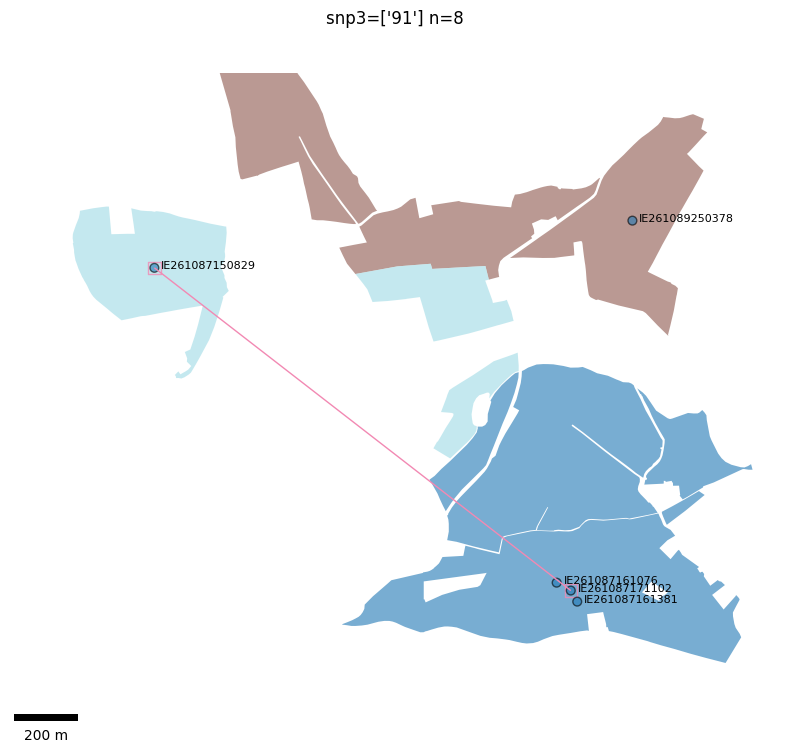

In [12]:
reload(trees)
def report(cent, parcels, lpis_cent, moves=None, aln=None, level='snp3', clades=[], cmap='tab20',
           labelcol='Animal_ID', outfile='report.pdf'):
    """Generate html and pdf report for cluster"""
    
    from weasyprint import HTML
    css_file = 'style.css'
    s = '<html>'
    s += '<head><link rel="stylesheet" href="%s"><head>' %css_file
    s += '<div class="title"><h3>cluster report (%s)</h3></div>'%datetime.now().strftime("%Y-%m-%d %H:%M")    

    for clade in clades:
        sub = cent[cent[level]==clade].copy()    
        herds = list(sub.HERD_NO)
        p = parcels[parcels.SPH_HERD_N.isin(herds)]    
        cols = ['Animal_ID','HERD_NO','County','Year','Species']
        #print (sub)
        #plot map
        fig,ax=plt.subplots(1,1,figsize=(8,8))    
        p.plot(column='SPH_HERD_N',alpha=0.6,lw=1,cmap=cmap,ax=ax)
        if moves is not None:
            mov = gui.get_moves_bytag(sub, moves, lpis_cent)
            gui.plot_moves(mov, lpis_cent, ax=ax)

        idx = sub[sub.duplicated('geometry')].index
        sub['geometry'] = sub.apply(lambda x: gui.jitter_points(x,50) if x.name in idx else x.geometry,1)
        gui.plot_single_cluster(sub,col=level,ax=ax)
        gui.show_labels(sub, labelcol, ax)

        #cx.add_basemap(ax, crs=cent.crs, 
        #        attribution=False, source=gui.providers['OSM'])
        
        fig.suptitle('%s=%s n=%s' %(level,clades,len(sub)))
        plt.tight_layout()
        tempname = tempfile.mktemp()
        fig.savefig(tempname, format='svg', dpi=150)
    
        #tree
        treehtml = ''
        if aln is not None:
            idx = list(sub.index)
            seqs = [rec for rec in aln if rec.id in idx]
            aln = MultipleSeqAlignment(seqs) 
            treefile = trees.tree_from_aln(aln)            
            canvas = trees.draw_tree(treefile, sub, 'HERD_NO', width=400)#, 'HERD_NO')#, cmap)
            toyplot.html.render(canvas, "temp.html")
            with open('temp.html', 'r') as f:
                treehtml = f.read()            
                #print (treehtml)
        #plot timeline of moves
        if moves is not None:
            fig,ax=plt.subplots(1,1,figsize=(8,3)) 
            gui.plot_moves_timeline(mov,ax)
            tempname2 = tempfile.mktemp()
            fig.savefig(tempname2, format='svg', dpi=150)
            
        s += '<h4>Clade %s</h4>' %clade
        s += '<div><img src="%s" class="small-scaled"></div>' % tempname  
        s += '<div>%s</div>' %treehtml
        s += '<div><img src="%s" class="small-scaled"></div>' % tempname2
        #tables
        table = '<div> %s</div>' %sub[cols].reset_index().to_html(classes="mytable",index=False)
        s+=table

    with open('report.html', 'w') as f:
        f.write(s)
   
    #html = HTML(string=s)
    html = HTML(string=open('report.html', 'rb').read(), base_url='./')
    
    html.write_pdf(outfile, stylesheets=[css_file],
                   optimize_images=True, jpeg_quality=80, dpi=150)
    return
    
report(cent, parcels, lpis_cent, moves, aln, clades=['91'])
